<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/lstm_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starting the Notebook



## Loading Dependencies

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main')

In [5]:
# !pip install -qqqq mlflow torchmetrics pytorch_lightning

In [6]:
import mlflow

In [7]:
memmap_meta_path = "src/data/memmap/memmap_meta.npz"
memmap_path = "src/data/memmap/memmap.npy"
df_diag_path = "src/data/records_w_diag_icd10.csv"
df_memmap_pkl_path = "src/data/memmap/df_memmap.pkl"


## Merge dataset with labels and ecg paths

In [9]:
import pandas as pd

df_diag = pd.read_csv(df_diag_path)
df_mapped = pd.read_pickle(df_memmap_pkl_path)

In [10]:
# merged_df = pd.merge(df_pkl, df_mapped, on=["study_id"], how="left")

## Labeling stroke classes

In [11]:
df_labels = df_diag['label_test'].apply(lambda x: 0 if x == '[]' else 1).to_frame(name='Stroke_YN')

In [12]:
df_labels.to_csv("src/data/labels.csv")

In [13]:
df_labels = pd.read_csv("src/data/labels.csv")

In [14]:
df_memmap_pkl_path = "src/data/memmap/df_memmap.pkl"
df_memmap = pd.read_pickle(df_memmap_pkl_path)

In [15]:
df_memmap.head()

,data,study_id,subject_id,ecg_time,nans,data_mean,data_std,data_length,data_original
0,0,43591201,11887165,2189-05-18 07:56:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.005497791, 0.02179162, 0.005907521, 0.02492...","[0.060382668, 0.095651895, 0.15717661, 0.19995...",1000,p11887165_s43591201.npy
1,1,49748010,11887165,2189-06-01 11:05:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-0.0061504985, 0.09458202, -0.075186834, -0.0...","[0.10248818, 0.09031134, 0.3013226, 0.37514743...",1000,p11887165_s49748010.npy
2,2,49403776,11887165,2189-05-20 16:40:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.007582335, 0.021146296, -0.020304434, -0.01...","[0.07482889, 0.099342495, 0.17699917, 0.184987...",1000,p11887165_s49403776.npy
3,3,43634761,11887165,2189-05-31 10:42:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.02220781, 0.01610101, -0.051529516, -0.0108...","[0.09561505, 0.084084064, 0.2251471, 0.2703747...",1000,p11887165_s43634761.npy
4,4,45332981,11887165,2189-06-02 10:32:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-0.07819419, -0.1401232, -0.056599084, -0.060...","[0.09305484, 0.07746841, 0.22321846, 0.3086269...",1000,p11887165_s45332981.npy


## Visualizing target class distribution

In [16]:
# Count the occurrences of each target class
target_counts = df_labels['Stroke_YN'].value_counts()
print(target_counts)

Stroke_YN
0    782005
1     18030
Name: count, dtype: int64


<ipython-input-17-33e75e129976>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")


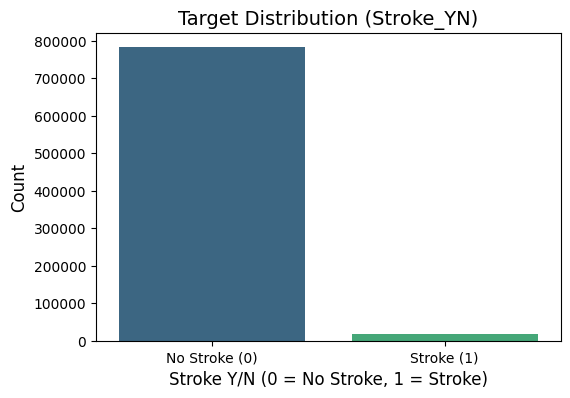

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
plt.title("Target Distribution (Stroke_YN)", fontsize=14)
plt.xlabel("Stroke Y/N (0 = No Stroke, 1 = Stroke)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], labels=["No Stroke (0)", "Stroke (1)"])
plt.show()

## Visualizing ECG Data

In [18]:
df = pd.read_csv("src/data/df_memmap.csv")
df.head()

,Unnamed: 0,Stroke_YN,start,length
0,0,0,0,1000
1,1,0,1000,1000
2,2,0,2000,1000
3,3,0,3000,1000
4,4,0,4000,1000


Original shape from metadata: (np.int64(800035000), np.int64(12))
Number of individual recordings: 800035
(9600420000,)
Reshaped ECG data: (800035000, 12)


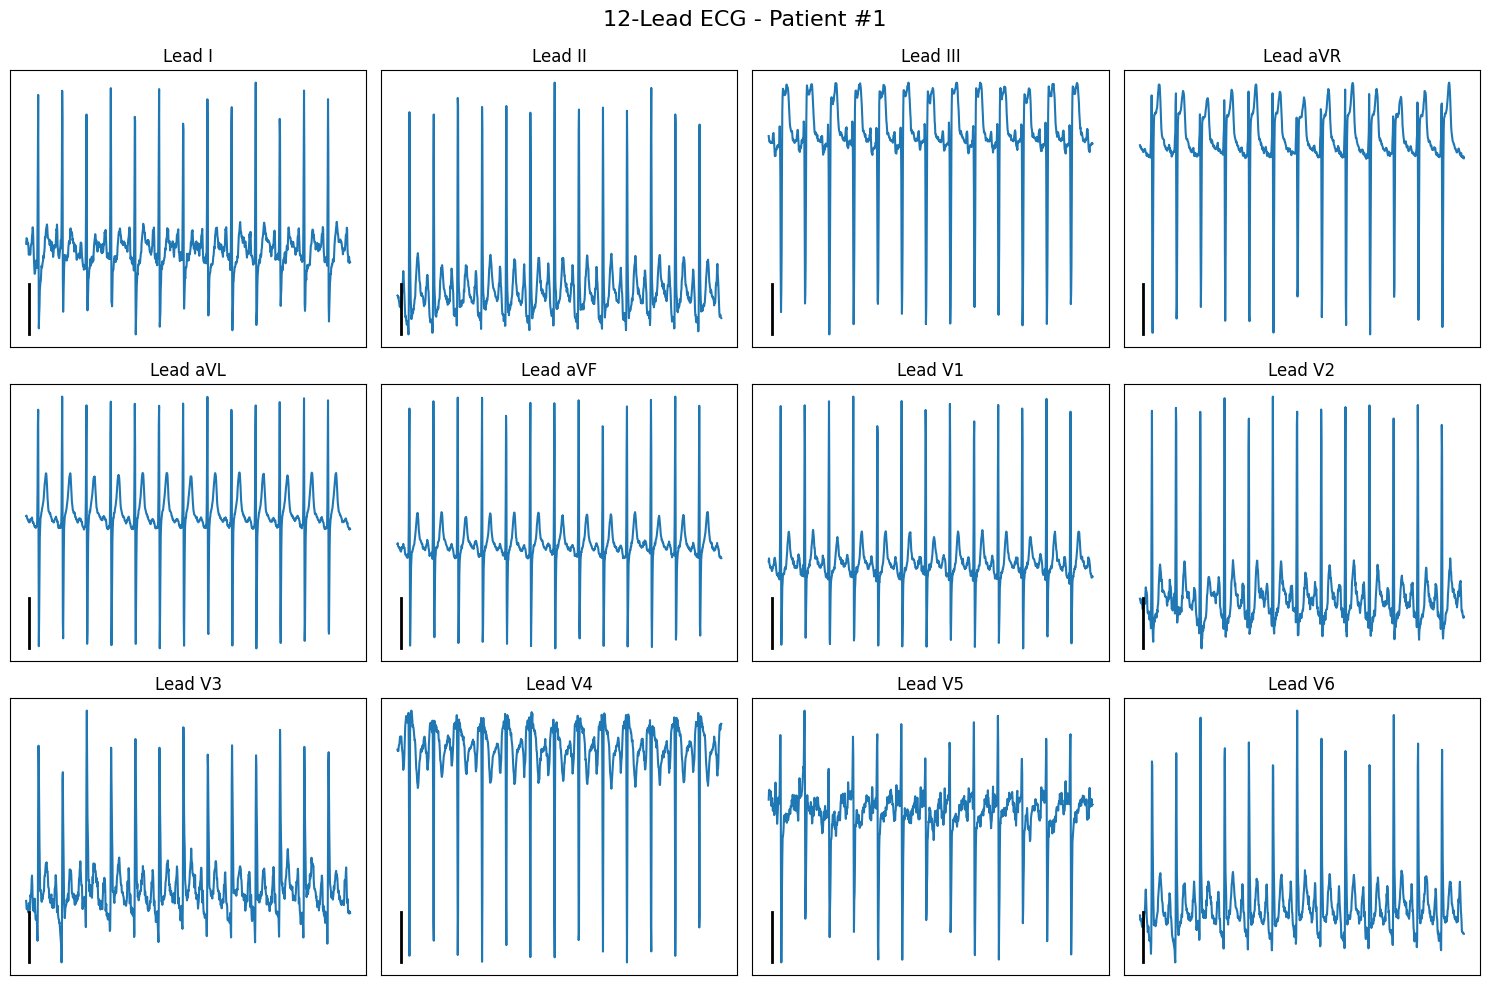

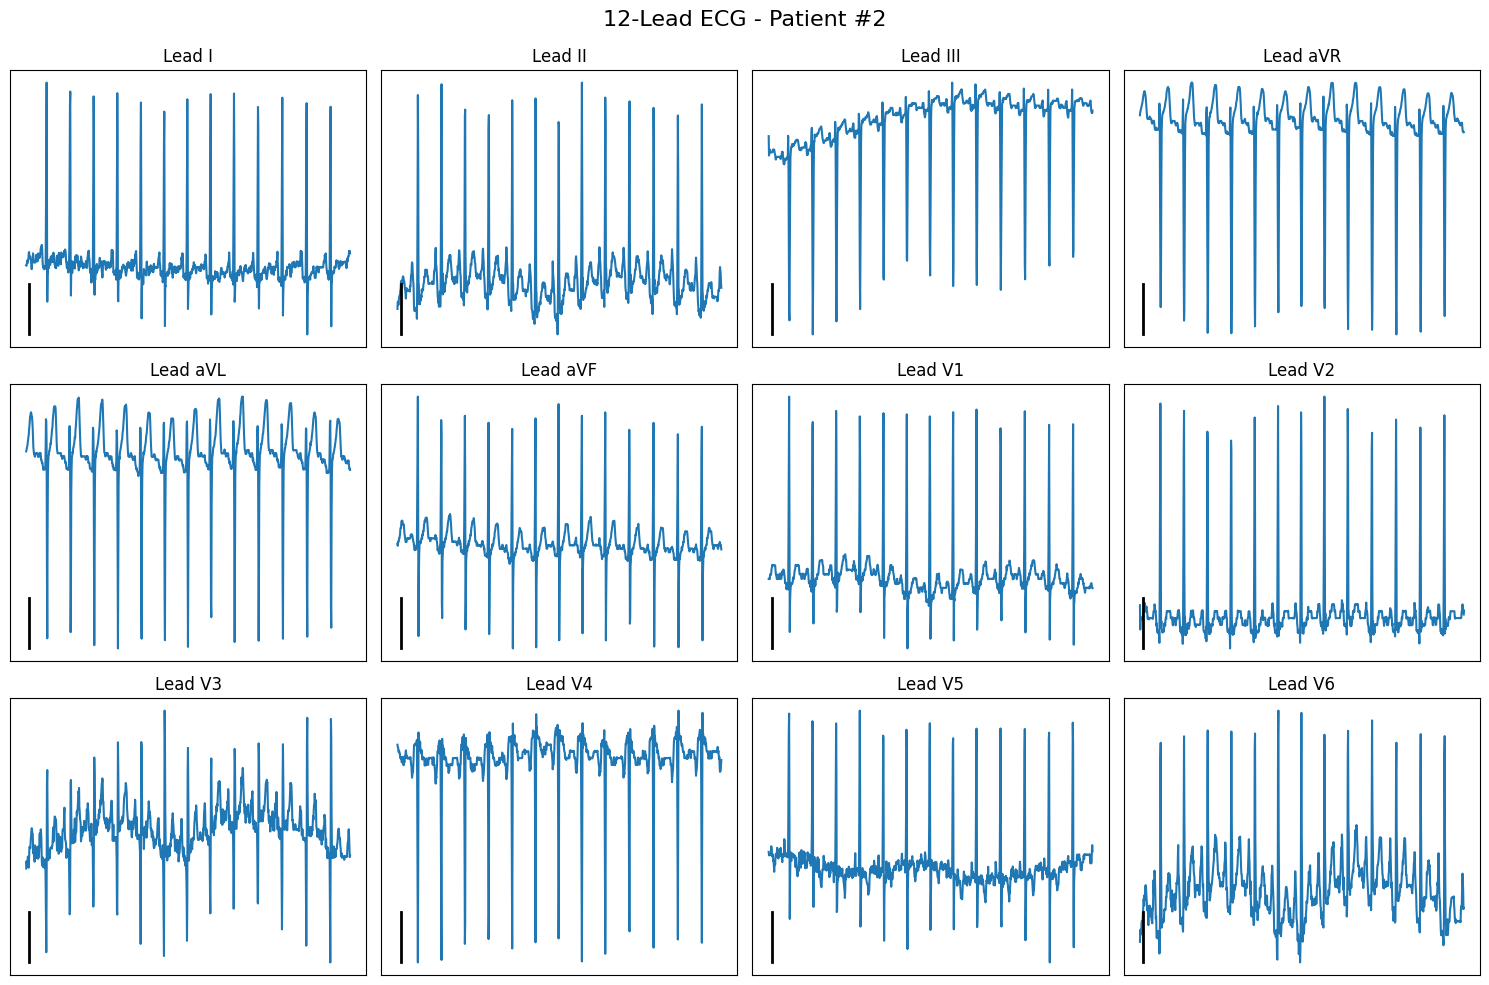

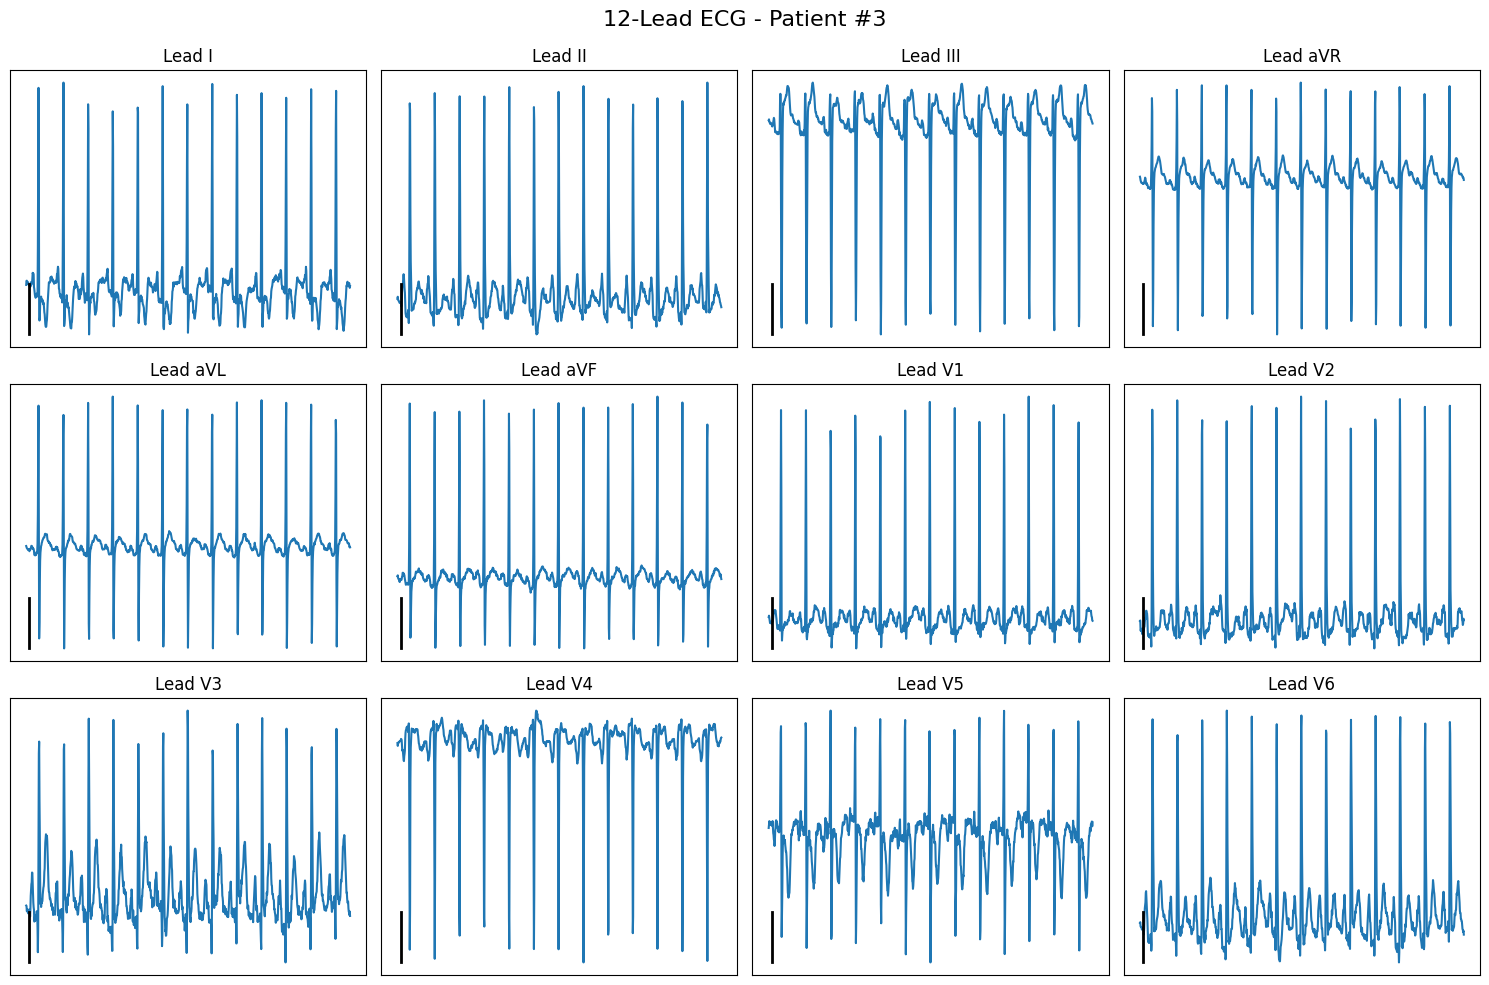

In [19]:
import numpy as np
import matplotlib.pyplot as plt

memmap_meta = np.load(memmap_meta_path, allow_pickle=True)
memmap_data = np.memmap(memmap_path, dtype=np.float32, mode='r')

starts = memmap_meta["start"]
lengths = memmap_meta["length"]
original_shape = tuple(memmap_meta["shape"][0])
print(f"Original shape from metadata: {original_shape}")
print(f"Number of individual recordings: {len(starts)}")
print(memmap_data.shape)
# Reshape data according to metadata
ecg_data = memmap_data.reshape(original_shape)
print(f"Reshaped ECG data: {ecg_data.shape}")

# Function to visualize a 12-lead ECG
def visualize_12lead_ecg(ecg_data, patient_index=0):
    # Get the start and length for this patient
    start_idx = starts[patient_index]
    length = lengths[patient_index]

    # Extract the data for this patient - all 12 leads
    patient_data = ecg_data[start_idx:start_idx+length, :]

    # Standard 12-lead ECG lead names
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    # Create a figure with 12 subplots (3x4 grid)
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    axes = axes.flatten()

    # Plot each lead
    for i, ax in enumerate(axes):
        if i < 12:  # We have 12 leads
            ax.plot(patient_data[:, i])
            ax.set_title(f'Lead {lead_names[i]}')
            ax.grid(True, alpha=0.3)

            # Add a small vertical scale bar (1 mV)
            # This is an approximation - normally would need calibration
            y_range = np.max(patient_data[:, i]) - np.min(patient_data[:, i])
            scale_bar = y_range * 0.2  # 20% of the range as a scale reference
            ax.plot([10, 10], [np.min(patient_data[:, i]), np.min(patient_data[:, i]) + scale_bar],
                   'k-', linewidth=2)

            # Remove tick labels to mimic clinical ECG appearance
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')  # Hide unused subplot

    # Add a title for the entire plot
    plt.suptitle(f'12-Lead ECG - Patient #{patient_index+1}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust to make room for suptitle

    return fig

# Visualize ECGs for first 3 patients
for i in range(3):
    fig = visualize_12lead_ecg(ecg_data, i)
    plt.figure(fig.number)
    plt.savefig(f'patient_{i+1}_12lead_ecg.png', dpi=300, bbox_inches='tight')
    plt.show()

# Basic statistics
# print("\nStatistics for all ECG data:")
# print("Min value:", ecg_data.min())
# print("Max value:", ecg_data.max())
# print("Mean:", ecg_data.mean())
# print("Standard deviation:", ecg_data.std())

## Data Class

In [20]:
import torch
from torch.utils.data import Dataset

class ECGDataset(Dataset):
    def __init__(self, memmap, labels_df):
        self.df = labels_df
        self.memmap = memmap

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      # Access data directly from the DataFrame
      start = self.df.loc[idx, 'start']
      length = self.df.loc[idx, 'length']
      # file_idx = self.df.loc[idx, 'file_idx'] # You might not need file_idx here anymore

      # Extract the flat signal slice
      signal = self.memmap[start : start + length * 12]  # 12 features per timestep
      signal = (signal - signal.mean(axis=0)) / (signal.std(axis=0) + 1e-6)

      # Reshape to [length, 12]
      signal = signal.reshape(length, 12)

      # Convert signal to PyTorch tensor before checking for NaN/inf
      signal = torch.tensor(signal, dtype=torch.float32)

      if torch.isnan(signal).any() or torch.isinf(signal).any():
        return None

      label = self.df.loc[idx, 'Stroke_YN']  # Access label from DataFrame
      return signal, torch.tensor(label, dtype=torch.long) # signal is already a tensor


## Swish

In [21]:
import pytorch_lightning as pl
import torch

class Swish(pl.LightningModule):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

## ConvNormPool

In [22]:
class ConvNormPool(pl.LightningModule):
    """Conv Skip-connection module"""
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x


# CNN

In [23]:
class CNN(pl.LightningModule):
    def __init__(
        self,
        input_size = 1,
        hid_size = 256,
        kernel_size = 5,
        num_classes = 5,
    ):

        super().__init__()

        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size//2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size//2,
            hidden_size=hid_size//4,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size//4, out_features=num_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        # print(x.shape) # num_features * num_channels
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)
        return x


# RNN

In [24]:
class RNN(pl.LightningModule):
    """RNN module(cell type lstm or gru)"""
    def __init__(
        self,
        input_size,
        hid_size,
        num_rnn_layers=1,
        dropout_p = 0.2,
        bidirectional = False,
        rnn_type = 'lstm',
    ):
        super().__init__()

        if rnn_type == 'lstm':
            self.rnn_layer = nn.LSTM(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )

        else:
            self.rnn_layer = nn.GRU(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )
    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states


# RNN Model

In [25]:
class RNNModel(pl.LightningModule):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,#hid_size * 2 if bidirectional else hid_size,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x, _ = self.rnn_layer(x)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.sigmoid(self.fc(x), dim=1)#.squeeze(1)
        return x


# RNN Attention Model

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryAUROC

class RNNAttentionModel(pl.LightningModule):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        kernel_size=5,
        lr=1e-3,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.conv1 = ConvNormPool(
            input_size=input_size,  # input_size = 12 for ECG
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )

        self.rnn_layer = RNN(
            input_size=hid_size,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )

        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=1)  # Binary output
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.lr = lr

        # Metrics
        self.train_acc = BinaryAccuracy()
        self.train_f1 = BinaryF1Score()
        self.train_auc = BinaryAUROC()

        self.val_acc = BinaryAccuracy()
        self.val_f1 = BinaryF1Score()
        self.val_auc = BinaryAUROC()

    def forward(self, input):
        input = input.permute(0, 2, 1)  # (batch, 12, 1000)
        x = self.conv1(input)
        x = self.conv2(x)
        x = x.permute(0, 2, 1)  # (batch, time_steps, features)

        x_out, _ = self.rnn_layer(x)  # (batch, time, hid_size)

        attn_weights = torch.softmax(self.attn(x_out), dim=1)  # (batch, time, hid_size)
        x = torch.sum(attn_weights * x_out, dim=1)  # (batch, hid_size)

        logits = self.fc(x)  # (batch, 1)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze()
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)
        preds = probs > 0.5

        acc = self.train_acc(probs, y.int())
        f1 = self.train_f1(probs, y.int())
        auc = self.train_auc(probs, y.int())

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        self.log("train_f1", f1, prog_bar=True)
        self.log("train_auc", auc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze()
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)
        preds = probs > 0.5

        acc = self.val_acc(probs, y.int())
        f1 = self.val_f1(probs, y.int())
        auc = self.val_auc(probs, y.int())

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_auc", auc, prog_bar=True)

    def on_test_start(self):
        self.test_probs = []
        self.test_preds = []
        self.test_targets = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()

        self.test_probs.append(probs.detach().cpu())
        self.test_preds.append(preds.detach().cpu())
        self.test_targets.append(y.detach().cpu())

    def on_test_end(self):
        self.all_probs = torch.cat(self.test_probs)
        self.all_preds = torch.cat(self.test_preds)
        self.all_targets = torch.cat(self.test_targets)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [27]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion


In [28]:
## Safe collate

In [29]:
from torch.nn.utils.rnn import pad_sequence
def safe_collate(batch):
    # Filter out None entries
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None  # Skip entire batch if empty (optional, or raise Exception)

    signals, labels = zip(*batch)
    signals = pad_sequence(signals, batch_first=True)  # if variable-length ECG
    labels = torch.tensor(labels)
    return signals, labels


In [30]:
from torch.utils.data import DataLoader
class ECGDataModule(pl.LightningDataModule):
    def __init__(self, memmap, train_df, val_df, test_df, batch_size=32):
        super().__init__()
        self.memmap = memmap
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = ECGDataset(self.memmap, self.train_df)
        self.val_dataset = ECGDataset(self.memmap, self.val_df)
        self.test_dataset = ECGDataset(self.memmap, self.test_df)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=11, collate_fn=safe_collate, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,  num_workers=11, collate_fn=safe_collate, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=11, collate_fn=safe_collate, pin_memory=True)


# Simple LSTM Model

In [31]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torchmetrics.classification import BinaryF1Score, BinaryAUROC


class LSTMSleepClassifier(pl.LightningModule):
    def __init__(self, input_size=12, hidden_size=64, num_layers=2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )


        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()
        self.test_f1 = BinaryF1Score()

        self.train_auc = BinaryAUROC()
        self.val_auc = BinaryAUROC()
        self.test_auc = BinaryAUROC()

        self.fc = nn.Linear(hidden_size * 2, 1)  # bidirectional
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(self.device))

    def forward(self, x):
        # x: (B, T, C) → needs to be (B, T, 12)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last timestep
        logits = self.fc(out)
        return logits.squeeze()

    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)
        preds = probs > 0.5
        auc = self.train_auc(probs, y.int())
        acc = (preds == y).float().mean()
        f1 = self.train_f1(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        self.log("train_f1", f1, prog_bar=True)
        self.log("train_auc", auc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)
        preds = probs > 0.5
        auc = self.train_auc(probs, y.int())
        acc = (preds == y).float().mean()
        f1 = self.val_f1(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_auc", auc, prog_bar=True)

        return loss


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)
        preds = probs > 0.5
        auc = self.train_auc(probs, y.int())

        acc = (preds == y).float().mean()
        f1 = self.test_f1(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_auc", auc, prog_bar=True)

        return loss

    # def configure_gradient_clipping(
    #     self,
    #     optimizer=None,
    #     optimizer_idx=None,
    #     gradient_clip_val=None,
    #     gradient_clip_algorithm=None
    # ):
    #     if optimizer is not None:
    #         torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)



    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)  # Reduced lr


## Data Sampling

In [32]:
import pandas as pd
import numpy as np

# Define paths
df_path = "src/data/df_memmap.csv"
train_df_path = "src/data/train_df.csv"
val_df_path = "src/data/val_df.csv"
test_df_path = "src/data/test_df.csv"

# Check if all files exist
if os.path.exists(df_path) and os.path.exists(train_df_path) and os.path.exists(val_df_path):
  print("Skipping Data labeling")
  df = pd.read_csv(df_path)
  train_df = pd.read_csv(train_df_path)
  val_df = pd.read_csv(val_df_path)
  test_df = pd.read_csv(test_df_path)

else:
  memmap_data = np.memmap(memmap_path, dtype=np.float32, mode='r')
  # memmap_data = torch.tensor(memmap_data).to("cuda")
  meta = np.load(memmap_meta_path, allow_pickle=True)
  start = meta['start']
  length = meta['length']

  # Load labels CSV
  df = df_labels.copy()

  # Sanity check
  assert len(df) == len(start), "Mismatch between label and memmap metadata length"

  # Add metadata into DataFrame
  df['start'] = start
  df['length'] = length

  # Now you can split the DataFrame while keeping track of ECG data pointers
  from sklearn.model_selection import train_test_split

  # Split test set with preserved stroke ratio
  train_val_df, test_df = train_test_split(
      df, test_size=0.10, stratify=df['Stroke_YN'], random_state=42
  )

  # Then split stroke/non-stroke from train_val_df as discussed before
  stroke_df = train_val_df[train_val_df['Stroke_YN'] == 1]
  nonstroke_df = train_val_df[train_val_df['Stroke_YN'] == 0]

  # Balanced sampling
  train_stroke, val_stroke = train_test_split(stroke_df, test_size=0.1, random_state=42)
  train_nonstroke = nonstroke_df.sample(n=len(train_stroke)*2, random_state=42)
  val_nonstroke = nonstroke_df.drop(train_nonstroke.index).sample(n=len(val_stroke)*2, random_state=42)

  # Final splits
  train_df = pd.concat([train_stroke, train_nonstroke]).reset_index(drop=True)
  val_df = pd.concat([val_stroke, val_nonstroke]).reset_index(drop=True)
  test_df = test_df.reset_index(drop=True)

  df.to_csv("src/data/df_memmap.csv", index=False)
  train_df.to_csv("src/data/train_df.csv", index=False)
  val_df.to_csv("src/data/val_df.csv", index=False)
  test_df.to_csv("src/data/test_df.csv", index=False)

Skipping Data labeling


In [33]:
from sklearn.utils.class_weight import compute_class_weight

labels = train_df["Stroke_YN"].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=labels)

# class_weights[1] is the weight for positive class
pos_weight = class_weights[1] / class_weights[0]  # Convert to ratio


Model and data Initialization

In [34]:
# Create the data module
ecg_dm = ECGDataModule(
    memmap=memmap_data,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    batch_size=64
)

## Setting up Mlflow for model baseline tracking

# Model Training

In [35]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import MLFlowLogger
import mlflow

import mlflow
import mlflow.pytorch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

os.environ['MLFLOW_TRACKING_USERNAME'] = "Zfeng0207"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "af7c8365aec4d3ff7a40563a35ec94d4bc9b4512"
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "stroke-prediction-dagshub-repo"
# Setup
experiment_name = "lstm-ecg"
tracking_uri = f"https://dagshub.com/{os.environ['MLFLOW_TRACKING_USERNAME']}/{os.environ['MLFLOW_TRACKING_PROJECTNAME']}.mlflow"

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)

print(f"MLflow tracking experiment name: {experiment_name}")
print(f"Tracking URI: {tracking_uri}")

# Use same URI in logger
mlf_logger = MLFlowLogger(
    experiment_name=experiment_name,
    tracking_uri=tracking_uri,
    log_model=True
)

MLflow tracking experiment name: lstm-ecg
Tracking URI: https://dagshub.com/Zfeng0207/stroke-prediction-dagshub-repo.mlflow


In [41]:
model = RNNAttentionModel(12, 64, 'lstm', False)
# model = RNNModel(1, 64, 'lstm', True)
# model = CNN(num_classes=5, hid_size=128)
# model = LSTMSleepClassifier(input_size=12)

In [43]:
trainer = Trainer(logger=mlf_logger, max_epochs=1,gradient_clip_val=1.0)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [51]:
trainer.fit(model, datamodule=ecg_dm)
trainer.test(model, datamodule=ecg_dm)
trainer.test(model, test_dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type              | Params | Mode 
---------------------------------------------------------
0  | conv1     | ConvNormPool      | 45.4 K | train
1  | conv2     | ConvNormPool      | 62.0 K | train
2  | rnn_layer | RNN               | 33.3 K | train
3  | attn      | Linear            | 4.1 K  | train
4  | fc        | Linear            | 65     | train
5  | loss_fn   | BCEWithLogitsLoss | 0      | train
6  | train_acc | BinaryAccuracy    | 0      | train
7  | train_f1  | BinaryF1Score     | 0      | train
8  | train_auc | BinaryAUROC       | 0      | train
9  | val_acc   | BinaryAccuracy    | 0      | train
10 | val_f1    | BinaryF1Score     | 0      | train
11 | val_auc   | BinaryAUROC       | 0      | train
---------------------------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


MlflowException: Invalid artifact path: 'epoch=0-step=685'. Names may be treated as files in certain cases, and must not resolve to other names when treated as such. This name would resolve to 'epoch=0-step=685'

## Evaluation Metrics

# Model Testing

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# After test finishes
y_true = model.all_targets.numpy()
y_pred = model.all_preds.numpy()
y_prob = model.all_probs.numpy()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'RNNAttentionModel' object has no attribute 'all_targets'

In [ ]:
import pandas as pd

# Create lists to hold signals and labels
signals = []
labels = []

for idx in range(len(df)):
    start = df.loc[idx, 'start']
    length = df.loc[idx, 'length']

    # Get and normalize the signal
    raw = memmap_data[start : start + length * 12]
    normed = (raw - raw.mean()) / (raw.std() + 1e-6)

    if np.isnan(normed).any() or np.isinf(normed).any():
        continue  # skip bad sample

    signal = normed.reshape(length, 12)
    signals.append(signal)
    labels.append(df.loc[idx, 'Stroke_YN'])

# Create DataFrame
df_signals = pd.DataFrame({
    "signal": signals,  # Each row is a 2D numpy array (object dtype)
    "label": labels
})

# RNN

In [ ]:
!pip install -qqqq tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense


In [ ]:
X_train = train_df[['start', 'length']].values
y_train = train_df['Stroke_YN'].values

X_val = val_df[['start', 'length']].values
y_val = val_df['Stroke_YN'].values

In [ ]:
def build_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
rnn_model = build_rnn_model()

In [ ]:
rnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=6,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              verbose=1,
                              patience=2,
                              min_lr=1e-6)

model_checkpoint = ModelCheckpoint('model.keras',
                                   monitor='val_loss',
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
rnn_history = rnn_model.fit(X_train_scaled, y_train,
                            epochs=10,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= callbacks)

In [ ]:
learning_curves_plot(rnn_history, start_epoch=0)

In [ ]:
# Predict on the test set
y_test_pred_rnn = rnn_model.predict(X_test_new).argmax(axis=1)

In [ ]:
# Evaluate RNN Model on Test Data
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"RNN Test Loss: {rnn_test_loss:.4f}")
print(f"RNN Test Accuracy: {rnn_test_acc:.4f}")

In [ ]:
# Classification report for RNN
print("RNN Classification Report:")
print(classification_report(y_test_new, y_test_pred_rnn))

In [ ]:
class_names = [labels[i] for i in range(len(labels))]

In [ ]:
# Confusion Matrix for RNN
conf_matrix_rnn = confusion_matrix(y_test_new, y_test_pred_rnn)

plot_confusion_matrix(conf_matrix_rnn,
                      class_names=class_names,
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('RNN Confusion Matrix')
plt.show()

# GRU

In [ ]:
def build_gru_model():
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
gru_model = build_gru_model()

In [ ]:
gru_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
gru_history = gru_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= callbacks)

In [ ]:
learning_curves_plot(gru_history, start_epoch=0)

In [ ]:
y_test_pred_gru = gru_model.predict(X_test_new).argmax(axis=1)

In [ ]:
# Evaluate GRU Model on Test Data
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"GRU Test Loss: {gru_test_loss:.4f}")
print(f"GRU Test Accuracy: {gru_test_acc:.4f}")

In [ ]:
# GRU classification report
print("GRU Classification Report:")
print(classification_report(y_test_new, y_test_pred_gru))

In [ ]:
# Confusion matrix for GRU
conf_matrix_gru = confusion_matrix(y_test_new, y_test_pred_gru)

plot_confusion_matrix(conf_matrix_gru,
                      class_names=class_names,
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('GRU Confusion Matrix')
plt.show()

# LSTM

In [ ]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
lstm_model = build_lstm_model()

In [ ]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
lstm_history = lstm_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= [reduce_lr, model_checkpoint])

In [ ]:
learning_curves_plot(lstm_history, start_epoch=0)

In [ ]:
y_test_pred_lstm = lstm_model.predict(X_test_new).argmax(axis=1)

In [ ]:
# Evaluate LSTM Model on Test Data
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")

In [ ]:
# LSTM classification report
print("LSTM Classification Report:")
print(classification_report(y_test_new, y_test_pred_lstm))

In [ ]:
# Confusion matrix for LSTM
conf_matrix_lstm = confusion_matrix(y_test_new, y_test_pred_lstm)

plot_confusion_matrix(conf_matrix_lstm,
                      class_names=class_names,
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('LSTM Confusion Matrix')
plt.show()